In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

In [2]:
#!wget -nc -O IDMT_Traffic.zip "https://zenodo.org/records/7551553/files/IDMT_Traffic.zip?download=1"
#!unzip -n IDMT_Traffic.zip > /dev/null

zsh:1: command not found: wget
unzip:  cannot find or open IDMT_Traffic.zip, IDMT_Traffic.zip.zip or IDMT_Traffic.zip.ZIP.


In [2]:
def import_idmt_traffic_dataset(fn_txt: str = "idmt_traffic_all") -> pd.DataFrame:
    """ Import IDMT-Traffic dataset
    Args:
        fn_txt (str): Text file with all WAV files
    Returns:
        df_dataset (pd.Dataframe): File-wise metadata
            Columns:
                'file': WAV filename,
                'is_background': True if recording contains background noise (no vehicle), False else
                'date_time': Recording time (YYYY-MM-DD-HH-mm)
                'location': Recording location
                'speed_kmh': Speed limit at recording site (km/h), UNK if unknown,
                'sample_pos': Sample position (centered) within the original audio recording,
                'daytime': M(orning) or (A)fternoon,
                'weather': (D)ry or (W)et road condition,
                'vehicle': (B)us, (C)ar, (M)otorcycle, or (T)ruck,
                'source_direction': Source direction of passing vehicle: from (L)eft or from (R)ight,
                'microphone': (SE)= (high-quality) sE8 microphones, (ME) = (low-quality) MEMS microphones (ICS-43434),
                'channel': Original stereo pair channel (12) or (34)
    """

    df_files = pd.read_csv(fn_txt, names=('file',))
    fn_file_list = df_files['file'].to_list()

    df_dataset = []

    for f, fn in enumerate(fn_file_list):
        fn = fn.replace('.wav', '')
        parts = fn.split('_')

        # background noise files
        if '-BG' in fn:
            date_time, location, speed_kmh, sample_pos, mic, channel = parts
            vehicle, source_direction, weather, daytime = 'None', 'None', 'None', 'None'
            is_background = True

        # files with vehicle passings
        else:
            date_time, location, speed_kmh, sample_pos, daytime, weather, vehicle_direction, mic, channel = parts
            vehicle, source_direction = vehicle_direction
            is_background = False

        channel = channel.replace('-BG', '')
        speed_kmh = speed_kmh.replace('unknownKmh', 'UNK')
        speed_kmh = speed_kmh.replace('Kmh', '')

        df_dataset.append({'file': fn,
                           'is_background': is_background,
                           'date_time': date_time,
                           'location': location,
                           'speed_kmh': speed_kmh,
                           'sample_pos': sample_pos,
                           'daytime': daytime,
                           'weather': weather,
                           'vehicle': vehicle,
                           'source_direction': source_direction,
                           'microphone': mic,
                           'channel': channel})

    df_dataset = pd.DataFrame(df_dataset, columns=('file', 'is_background', 'date_time', 'location', 'speed_kmh', 'sample_pos', 'daytime', 'weather', 'vehicle',
                                                   'source_direction', 'microphone', 'channel'))

    return df_dataset

In [3]:
import zipfile
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder  # OBBLIGATORIO DA USARE
from tensorflow.keras.utils import to_categorical  # OBBLIGATORIO DA USARE
from io import TextIOWrapper

# Percorso assoluto del file ZIP
ZIP_PATH = "/Volumes/Extreme SSD/IDMT_Traffic.zip"


# Apri lo ZIP senza estrarlo

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    all_audio_files = [f for f in zip_ref.namelist() if f.startswith("IDMT_Traffic/audio/") and f.endswith('.wav')]
    print(f"\nNumero totale di file audio trovati: {len(all_audio_files)}")
    
    # Leggi il file di annotazione
    with zip_ref.open("IDMT_Traffic/annotation/idmt_traffic_all.txt") as ann_file:
        df_dataset = pd.read_csv(TextIOWrapper(ann_file, 'utf-8'), sep="\t", header=None)

# Controlla struttura
print(df_dataset.head())
print(df_dataset.shape)

# Supponiamo che la colonna 'vehicle' sia la prima
vehicle = df_dataset[0]
le = LabelEncoder()
labels_encoded = le.fit_transform(vehicle)
labels_cat = to_categorical(labels_encoded)





Numero totale di file audio trovati: 17506
                                                   0
0  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1007744...
1  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1007744...
2  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1017344...
3  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1017344...
4  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1026944...
(17506, 1)


In [23]:
spectograms = []
fixed_length = None

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    for audio_path in all_audio_files[:]:   #RIDOTTO A 100 IN MODO TALE CHE SIA TUTTO PIù VELOCE
        with zip_ref.open(audio_path) as audio_file:
            y, sr = librosa.load(audio_file, sr=None)  # sr=None per usare la frequenza originale

            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

            if fixed_length is None:
                fixed_length = mel_spectrogram_db.shape[1]

            if mel_spectrogram_db.shape[1] < fixed_length:
                mel_spectrogram_db = np.pad(mel_spectrogram_db,
                                            ((0, 0), (0, fixed_length - mel_spectrogram_db.shape[1])),
                                            mode='constant')
            else:
                mel_spectrogram_db = mel_spectrogram_db[:, :fixed_length]

            spectograms.append(mel_spectrogram_db)


In [24]:
spectograms = np.array(spectograms)
spectograms = spectograms / np.max(np.abs(spectograms))
input_shape = spectograms.shape[1:]
print(spectograms.shape)
print(input_shape)

(17506, 128, 188)
(128, 188)


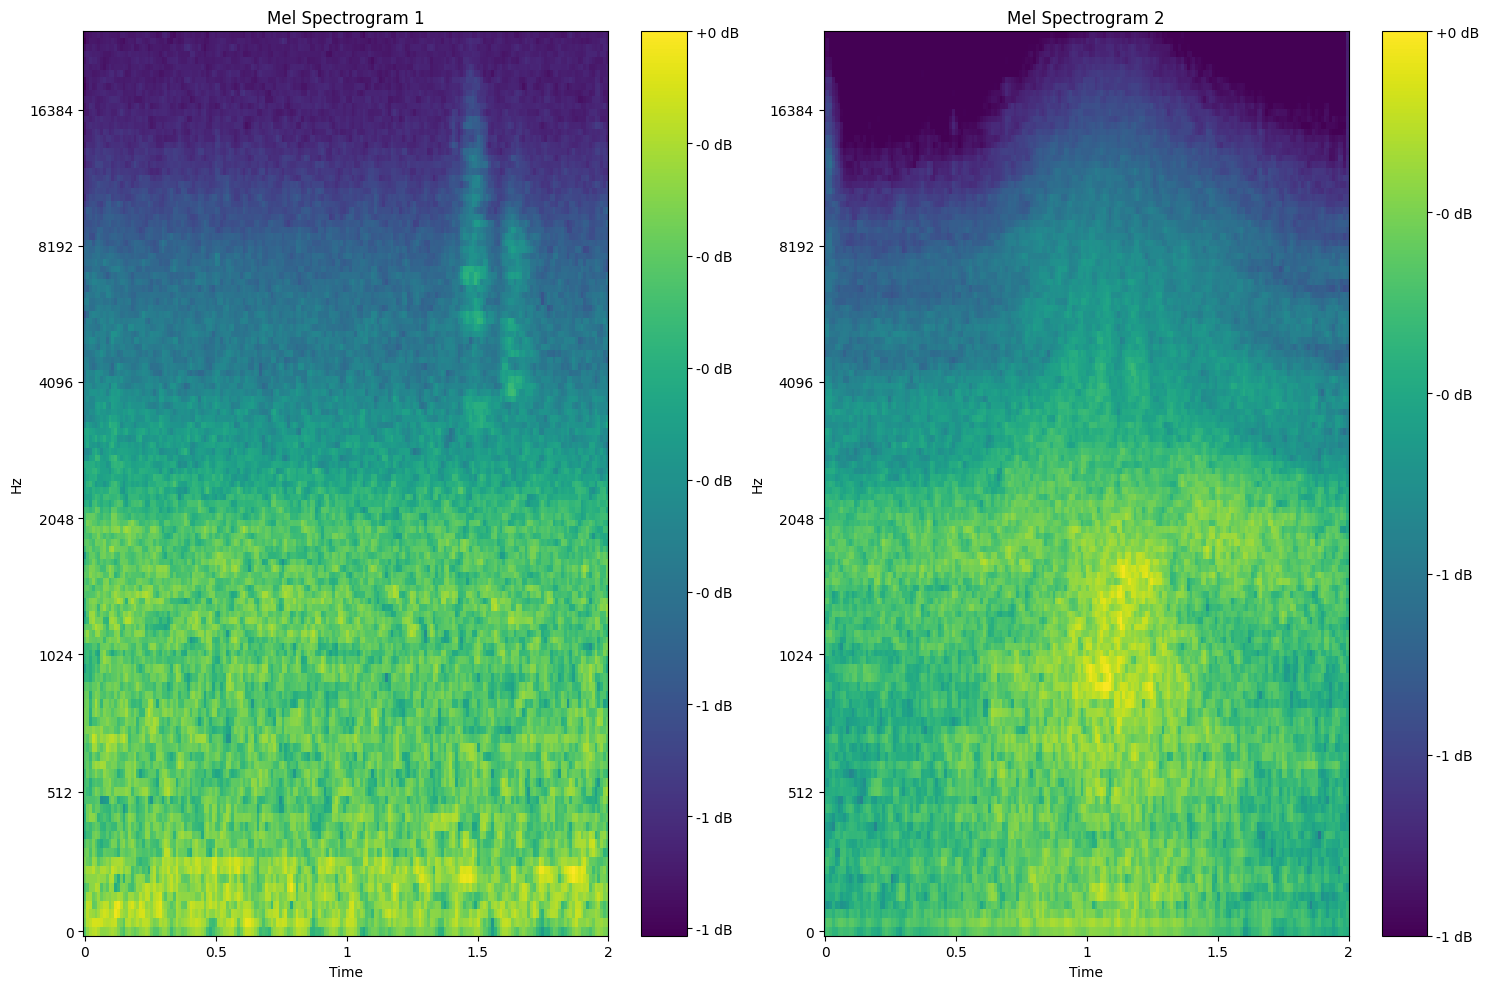

In [25]:
# visualization mel spectrogram

import matplotlib.pyplot as plt
import librosa.display

# Numero di spettrogrammi da visualizzare
n_to_plot = 2

plt.figure(figsize=(15, 10))

for i in range(n_to_plot):
    plt.subplot(1, n_to_plot, i + 1)
    librosa.display.specshow(spectograms[i], sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.title(f"Mel Spectrogram {i+1}")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

plt.show()

In [26]:
# Normalization and Padding

spectograms = []
fixed_length = None

def normalize_spectrogram(spec):
    spec_min = np.min(spec)
    spec_max = np.max(spec)
    return (spec - spec_min) / (spec_max - spec_min + 1e-6)

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    for audio_path in all_audio_files[:]:
        with zip_ref.open(audio_path) as audio_file:
            y, sr = librosa.load(audio_file, sr=None)

            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

            if fixed_length is None:
                fixed_length = mel_spectrogram_db.shape[1]

            # Padding o troncamento
            if mel_spectrogram_db.shape[1] < fixed_length:
                mel_spectrogram_db = np.pad(mel_spectrogram_db,
                                            ((0, 0), (0, fixed_length - mel_spectrogram_db.shape[1])),
                                            mode='constant')
            else:
                mel_spectrogram_db = mel_spectrogram_db[:, :fixed_length]

            # Normalizzazione
            mel_spectrogram_db = normalize_spectrogram(mel_spectrogram_db)

            spectograms.append(mel_spectrogram_db)


            

In [27]:
# Data Augmentation 

#augmented_versions = []

def random_window(y, sr, window_duration=2.0):
    """Estrae una finestra casuale di durata fissa dal segnale audio."""
    window_length = int(window_duration * sr)
    if len(y) <= window_length:
        return np.pad(y, (0, window_length - len(y)), mode='constant')
    else:
        start = np.random.randint(0, len(y) - window_length)
        return y[start:start + window_length]


# Esempio di una funzione di augmentazione
def augment_audio(y, sr):
    versions = []

    # Applica Random Window di 2 secondi
    y_crop = random_window(y, sr, window_duration=2.0)

    # Originale (crocato)
    versions.append(y_crop)

    # Pitch shift
    versions.append(librosa.effects.pitch_shift(y_crop, sr=sr, n_steps=2))

    # Time stretch
    y_stretched = librosa.effects.time_stretch(y_crop, rate=1.2)
    if len(y_stretched) > len(y_crop):
        y_stretched = y_stretched[:len(y_crop)]
    else:
        y_stretched = np.pad(y_stretched, (0, len(y_crop) - len(y_stretched)), mode='constant')
    versions.append(y_stretched)

    # Rumore
    versions.append(add_noise(y_crop, snr_db=10))

    # Impulse response (opzionale)
    # ir, _ = librosa.load('impulse_response.wav', sr=sr)
    # ir = ir / np.sqrt(np.sum(ir**2))
    # y_reverb = fftconvolve(y_crop, ir, mode='full')[:len(y_crop)]
    # versions.append(y_reverb)

    return versions




In [28]:
# Dataset Split

from sklearn.model_selection import train_test_split

# Supponiamo che ogni spettrogramma abbia una label associata
# Per ora creiamo un placeholder per le label (es. 0, 1, 2,...)
labels = np.arange(len(spectograms))  # sostituisci con le vere label se le hai

# Primo split: Train (70%) + Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    spectograms, labels, test_size=0.30, random_state=42, shuffle=True)

# Secondo split: Temp in Validation (15%) + Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True)

print(f"Train set: {len(X_train)} campioni")
print(f"Validation set: {len(X_val)} campioni")
print(f"Test set: {len(X_test)} campioni")




#FINISCE QUI



Train set: 12254 campioni
Validation set: 2626 campioni
Test set: 2626 campioni


In [8]:
model = tf.keras.models.Sequential()

model.add(tf.keras.Input(shape=(spectograms.shape[1], spectograms.shape[2], 1)))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1000, activation='relu'))
model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

AttributeError: 'list' object has no attribute 'shape'

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    spectograms, labels_cat, test_size=0.6, stratify=labels_encoded, random_state=42
)

ValueError: Found input variables with inconsistent numbers of samples: [100, 17506]

In [32]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.4773 - loss: 1.0035 - val_accuracy: 0.4653 - val_loss: 1.0049
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.4523 - loss: 0.9961 - val_accuracy: 0.4653 - val_loss: 1.0050
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.4641 - loss: 0.9957 - val_accuracy: 0.4653 - val_loss: 1.0047
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.4551 - loss: 1.0037 - val_accuracy: 0.4653 - val_loss: 1.0042
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.4620 - loss: 1.0241 - val_accuracy: 0.4653 - val_loss: 1.0072


NameError: name 'history' is not defined

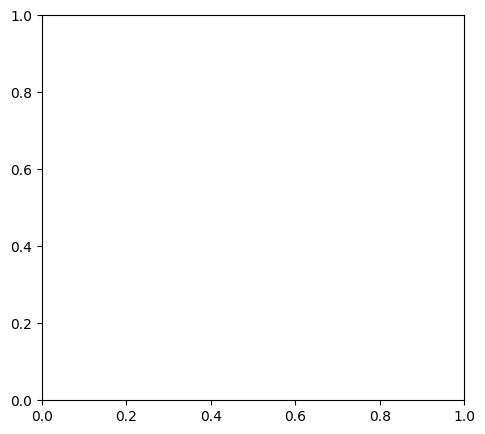

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()